In [8]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[1:55]].min()

def scale(x):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    scaler.fit(x)# + [0]*52)
    return scaler, scaler.transform(x)

In [3]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh)
            neigh.fit(x2, y)
            
            groups = list(df.index.get_level_values(0))
            cv=LeaveOneGroupOut().split(x2, y, groups)
            score = cross_val_score(neigh, x2, y, cv=cv).mean()
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [4]:
def graph(clf, pca, x2):
    if pca.n_components != 2:
        print('PCA must be 2D')

    norm = matplotlib.colors.LogNorm(vmin=y.min(), vmax=y.max())
    fig, ax = plt.subplots()
    
    plt.title('Prediction after dimensionality reduction')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # grid
    xmin = -6
    xmax = 16
    xstep = .3

    ymin = -2
    ymax = 3
    ystep = .3

    xrange = np.arange(xmin, xmax, xstep)
    yrange = np.arange(ymin, ymax, ystep)
    xx, yy = np.meshgrid(xrange, yrange)

    xrange_grid = np.arange(xmin-xstep/2, xmax+xstep/2, xstep)
    yrange_grid = np.arange(ymin-ystep/2, ymax+ystep/2, ystep)
    xx_grid, yy_grid = np.meshgrid(xrange_grid, yrange_grid)

    ypred = clf.predict(list(zip(xx.ravel(), yy.ravel())))
    ypred = [q if q>0 else y.min() for q in ypred]
    ypred = np.array(ypred).reshape(len(yrange_grid)-1, len(xrange_grid)-1)

    pcm = ax.pcolor(xx_grid, yy_grid, ypred, norm=norm)

    cbar = fig.colorbar(pcm, ax=ax, extend='max')
    cbar.set_label('Execution time (log scale)', rotation=270, va='top')

    # scatter
    ax.scatter(x2[:,0], x2[:,1], c=y, norm=norm, edgecolors='black', s=60)
    ax.set_ylim(-2, 3)

In [36]:
out_dir = '../papi_output/'
path = out_dir + 'all.csv'

df = pd.read_csv(path) #, header=None)
df = aggregate(df)

df2=df.copy()

for col in df.columns[:52]:
    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

x = df.iloc[:,:52].as_matrix()
scaler, x = scale(x)
y = df.iloc[:,52].as_matrix()

In [38]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 6), range(6, 12))

2 	 6 	 -14106249538.2
2 	 7 	 -10401800651.1
2 	 8 	 -19417504401.1
2 	 9 	 -15440473037.9
2 	 10 	 -12567448483.0
2 	 11 	 -23358940001.7
3 	 6 	 -5226532567.19
3 	 7 	 -10401800686.9
3 	 8 	 -8043582726.5
3 	 9 	 -15440473042.2
3 	 10 	 -12567448433.2
3 	 11 	 -23358939974.1
4 	 6 	 -1722598118.03
4 	 7 	 -1293267351.57
4 	 8 	 -3025567121.12
4 	 9 	 -6403506239.48
4 	 10 	 -5278975550.82
4 	 11 	 -10504660455.6
5 	 6 	 -1722598119.73
5 	 7 	 -3903254562.4
5 	 8 	 -3025567188.07
5 	 9 	 -6403506336.41
5 	 10 	 -12567448448.8
5 	 11 	 -10504660484.5
--------------
PCA:	 4
kNN:	 7
Score:	 -1293267351.57


In [24]:
pca = PCA(n_components=4)
pca.fit(x)
x2 = pca.transform(x)
pca.explained_variance_ratio_.sum()

0.91660571458080731

In [74]:
svr = SVR(kernel='linear', C=1, epsilon=.1)
svr.fit(x2, y)
clf = svr

In [64]:
#neigh = KNeighborsRegressor(n_neighbors=4, algorithm='brute', metric='mahalanobis', metric_params={'V': np.cov(x2)})
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(x2, y) 
clf = neigh

In [69]:
groups = list(df.index.get_level_values(0))
cv=LeaveOneGroupOut().split(x2, y, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]
scores = cross_val_score(clf, x2, y, cv=cvres)

print('\n'.join([str(round(s, 2))+'\t'+g for g, s in zip(group_names, scores)]))
scores.mean()

-18.23	lore_01cf7c0b-6bab-4b40-bb87-04882b6d4355
-225440.93	lore_01ff0407-3b9e-4eb4-95ea-b97d11e924ed
-17.81	lore_071e0363-89a9-4aac-9f74-05b0f47c1098
-31.03	lore_0d2642ab-85bc-417b-9f83-bfbd62171a51
-36.77	lore_143b62e2-2cf7-4f05-a541-4876545e473f
-45.23	lore_1a975b28-5fb4-4947-8d08-73351b4510b9
-87.12	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66
-4349.13	lore_23155c0c-6959-43e3-957b-9e85593448bd
-61945.9	lore_26166dea-4a8b-479a-a5d8-04b381eb077a
-95249.08	lore_29c2d099-a988-4007-a692-75c8f4f14f44
-62.83	lore_2a2b23f4-844c-4f9f-9fb3-0b8ebc545110
-140.44	lore_2b575b90-58f1-46a3-a7c6-5fe19f136533
0.26	lore_2f42f981-fec7-4895-bde2-5dae96e3ce5d
-2152.8	lore_301d9585-272e-4ae4-b0df-f34f93841fae
-28.39	lore_32b40809-38d8-4172-a3f8-597ccfa4ffff
-17678.44	lore_3a9b6142-ebfa-46bb-b03a-b90dd3063234
-75309.37	lore_3c801a34-bb19-4c51-8b39-b3bdde4e9213
-34.8	lore_45b5111a-30d1-414a-ac0a-5c58f1d51f37
-55510329.25	lore_45f798f8-0155-4c1a-a729-392483621301
-14672.23	lore_5146769f-df15-403c-8489-6b25eb39

-990912.15340838011

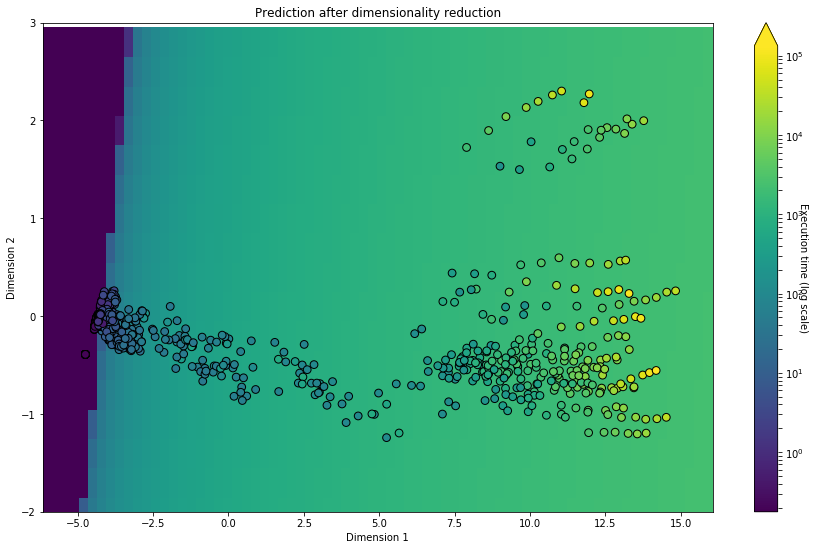

In [81]:
graph(clf, pca, x2)

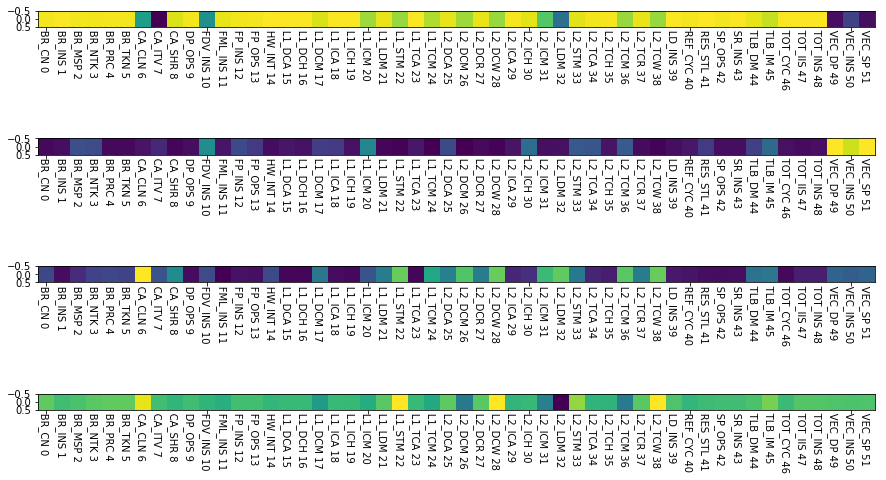

In [14]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    for j, txt in enumerate(lab):
        ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    ax.imshow(pca.components_[i:i+1])
    ax.set_xticklabels([])
plt.show()

In [21]:
xtest = [4497449,7371,1328063,99,4448118,1328162,12325,20770,0,5452469,373413,5811940,973353,-714272,2042434,171,201090867,200906169,9991,9953,201080819,3756817690,3705109141,0,1505390728,198404403,199318100,0,883212989,2100347613,1953588754,1958086203,6785293,5811940,973353,1818994023,12747,1819001394,12846,5512011,3777087597,6840173,5824786,973353,0,0,0,0,0,0,0,2088825402]
ytrue = 1120
xtest = [np.log(q) if q>0 else 0 for q in xtest]
xtest = scaler.transform([xtest])
xtest = pca.transform(xtest)
print('pca: ', xtest)
neigh.predict(xtest)

pca:  [[ 6.37173282  2.34557423 -5.09183212 -3.47886378]]


array([ 5239.94933333])

In [225]:
xtest = df.iloc[:30,1:53].as_matrix()
scaler, xtest = scale(xtest)
ytest = df.iloc[:30,53].as_matrix()
xtest = pca.transform(xtest)
ypred = clf.predict(xtest)
for yp, yt in zip(ypred, ytest):
    print(int(yp), '\t', int(yt))

3522 	 1182
81 	 86
80410 	 90237
11 	 4
9 	 4
14682 	 10960
788 	 614
1770 	 2006
5842 	 2706
43 	 34
7 	 6
72213 	 25082
17229 	 10150
73 	 57
60747 	 42265
100 	 70
10047 	 1778
3584 	 1584
236 	 112
7510 	 4277
67 	 73
56 	 43
8394 	 4809
928 	 214
698 	 828
11925 	 4675
5011 	 2429
11 	 6
7217 	 5799
49952 	 49380


In [30]:
df['PAPI_VEC_INS'].max()

15.476360337755873

In [40]:
[(col, df2[col].min(), df2[col].max()) for col in df2.columns]

[('PAPI_BR_CN', 0, 22006717790),
 ('PAPI_BR_INS', 0, 22012646095),
 ('PAPI_BR_MSP', 0, 14042221),
 ('PAPI_BR_NTK', 0, 48042218),
 ('PAPI_BR_PRC', 0, 21998879118),
 ('PAPI_BR_TKN', 0, 21960188302),
 ('PAPI_CA_CLN', 0, 12157615),
 ('PAPI_CA_ITV', 0, 0),
 ('PAPI_CA_SHR', 0, 144941),
 ('PAPI_DP_OPS', 0, 88110548069),
 ('PAPI_FDV_INS', 0, 1993308223),
 ('PAPI_FML_INS', 0, 88185713609),
 ('PAPI_FP_INS', 0, 88110548069),
 ('PAPI_FP_OPS', 0, 88110548069),
 ('PAPI_HW_INT', 0, 34913),
 ('PAPI_L1_DCA', 0, 466169753240),
 ('PAPI_L1_DCH', -611491, 464772785062),
 ('PAPI_L1_DCM', 0, 3879566814),
 ('PAPI_L1_ICA', 0, 438134136902),
 ('PAPI_L1_ICH', -1664, 438134051789),
 ('PAPI_L1_ICM', 0, 5263536),
 ('PAPI_L1_LDM', 0, 5492320047),
 ('PAPI_L1_STM', 0, 210900939),
 ('PAPI_L1_TCA', 0, 904303890142),
 ('PAPI_L1_TCM', 0, 3872609288),
 ('PAPI_L2_DCA', 0, 5492471140),
 ('PAPI_L2_DCM', -276, 1374775047),
 ('PAPI_L2_DCR', 0, 5492320047),
 ('PAPI_L2_DCW', 0, 210900939),
 ('PAPI_L2_ICA', 0, 167936),
 ('PAPI_L2_